# Import libraries

In [27]:
import base64
import requests
import json
import spacy
from IPython.display import display
from PIL import Image

#from sentence_transformers import SentenceTransformer
#from sklearn.metrics.pairwise import cosine_similarity
#from fatsecret import Fatsecret

# Functions

In [4]:
TRANSLATIONS = {
    "English": {
        "unable_to_identify": "Unable to identify any food items in this image. Please try again with a different image.",
        "unable_to_analyze": "Unable analyze this image. Please try again.",
        "unable_to_retrieve_nutri_info": "Unable to retrieve the nutritional information of the foods in the image. Please try again."
    },
    "Spanish": {
        "unable_to_identify": "No se logró identificar alimentos en la imagen. Por favor, prueba nuevamente con una imagen distinta.",
        "unable_to_analyze": "No se logró analizar la imagen. Por favor, intenta de nuevo.",
        "unable_to_retrieve_nutri_info": "No se logró obtener la información nutricional de los alimentos en la imagen. Por favor, intenta de nuevo."
    },
    "Portuguese": {
        "unable_to_identify": "Não é possível identificar itens alimentares nesta imagem. Por favor, tente novamente com uma imagem diferente.",
        "unable_to_analyze": "Não é possível analisar esta imagem. Por favor, tente novamente.",
        "unable_to_retrieve_nutri_info": "Não foi possível obter as informações nutricionais dos alimentos na imagem. Por favor, tente novamente."
    },
}

In [5]:
# Function to encode an image file to base64 string
def encode_image(image_path):
    # Open the image file in binary read mode
    with open(image_path, "rb") as image_file:
        # Read the image file and encode it to base64, then decode the bytes object to a string
        return base64.b64encode(image_file.read()).decode('utf-8')

In [20]:
# Function to evaluate an image using an external API, with optional parameters
def evaluate_image(image_path, prompt = None, country = 'Uruguay', language = 'English', temperature = 0.0):

    # Check if a custom prompt is not provided
    if prompt is None:
        # Generate a detailed prompt for the API request focusing on food item identification
            
        prompt = f"""Analyze the image to identify all visible food items, taking into account that the meal was consumed in {country} and the food identification should be in {language}. Format the results in JSON, detailing each food item as follows:
            [{{
            'food_name': [String] Use a basic descriptor suitable for a nutritional database, in {language}. Include only single-ingredient or primary food items (e.g., 'Spaghetti', 'Tomato sauce'), not mixtures ('Spaghetti with tomato sauce'). Add descriptors like 'grilled' or 'fried' only if they significantly alter nutritional value. Strictly avoid adjectives that merely describe physical form ('shredded', 'grated', 'sliced'),
            'unit': [String] Provide the unit in singular form, in english (e.g., 'piece', 'slice', 'cup'),
            'quantity': [int or float] Provide an estimated count or volume,
            'g_equivalent': [int or float] Approximate weight in grams for the given quantity,
            'ml_equivalent': [int or float] For liquids, provide the approximate volume in milliliters,
            }},
            {{...}}]

            Focus on the type and critical characteristics of each item that influence its nutritional profile, while omitting unnecessary descriptive adjectives and composites like 'grated' and 'shredded'.
            """
    
    # API key for authorization with the external service
    api_key = "sk-proj-Pr6KxJ1BcWXpFMobYWgZT3BlbkFJx9vroD8194dVqJB3t6TR"
    # URL of the API endpoint
    url = "https://api.openai.com/v1/chat/completions"

    # Encode the provided image to base64 format
    base64_image = encode_image(image_path)

    # Headers for the HTTP request, including Content-Type and Authorization
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    # JSON payload for the API request, containing the model, messages, max_tokens and temperature
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                }
            }
            ]
        }
        ],
        "max_tokens": 500,
        "temperature": temperature,
    }

    try:
        # Execute the API request with the specified URL, headers, and payload
        response = requests.post(url, headers=headers, json=payload)
        
        try:
            # Parse the response
            response_dict = response.json()
            
            try:
                # Extract content from the parsed response
                response_content = response_dict['choices'][0]['message']['content']
                
                # Locate the JSON formatted response within the content
                start_index = response_content.find("[")
                end_index = response_content.rfind("]") + 1
                json_data = response_content[start_index:end_index]

                try:
                    # Parse the JSON response content to a Python object (list of dictionaries)
                    foods_list = json.loads(json_data)
                    
                    # Check that the foods list is not empty
                    if len(foods_list) > 0:
                        status = "Ok"
                        status_message = "Successfully extracted foods list from response."
                        message_for_user = None
                    else:
                        status = "Error"
                        status_message = "Got response, but extracted food list was found empty."
                        message_for_user = TRANSLATIONS[language]["unable_to_identify"]
            
                except:
                    # If parsing fails, store error message
                    status = "Error"
                    status_message = "Got response, but failed to extract foods list from response content."
                    message_for_user = TRANSLATIONS[language]["unable_to_identify"]
                    foods_list = None
                    
            except:
                # If the response does not contain the expected content, store an error message
                status = "Error"
                status_message = "Got response, but failed to extract content from response."
                message_for_user = TRANSLATIONS[language]["unable_to_analyze"]
                foods_list = None
        except:
            status = "Error"
            status_message = "Got response, but failed to parse response."
            message_for_user = TRANSLATIONS[language]["unable_to_analyze"]
            response_dict = None
            foods_list = None
            
    except:
        # If the request fails, store an error message
        status = "Error"
        status_message = "Failed to execute request."
        message_for_user = TRANSLATIONS[language]["unable_to_analyze"]
        foods_list = None
        response_dict = None
        
    result = {"status": status,
            "status_message": status_message,
            "message_for_user": message_for_user,
            "parsed_response": response_dict,
            "foods_list": foods_list}
    
    # Return the results
    return result

In [25]:
def format_response(response):
    # Formatear y mostrar la respuesta completa
    print("Status:", response.get('status', 'N/A'))
    print("Status Message:", response.get('status_message', 'N/A'))
    print("Message for User:", response.get('message_for_user', 'N/A'))
    
    print("\nParsed Response:")
    parsed_response = response.get('parsed_response', {})
    print(json.dumps(parsed_response, indent=4))
    
    print("\nFoods List:")
    foods_list = response.get('foods_list', [])
    for food in foods_list:
        print(json.dumps(food, indent=4))

# Testing

## Image 1

In [44]:
image_path = "test-data/Foodvisor1.png"

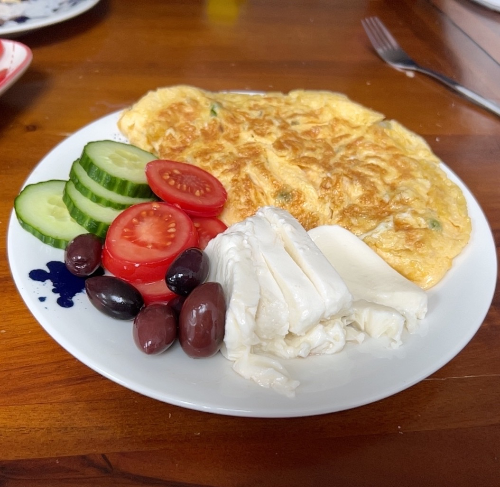

In [45]:
img = Image.open(image_path)

display(img)

Valores aproximados en gramos:
* 34 aceitunas negras
* 112 omelette
* 70 pepino
* 17 tomates cherry
* 50 queso mozzarella

In [46]:
rta_img1 = evaluate_image(image_path=image_path, country="Argentina")

In [47]:
format_response(rta_img1)

Status: Ok
Status Message: Successfully extracted foods list from response.
Message for User: None

Parsed Response:
{
    "id": "chatcmpl-9gzWyLzfojC9IbfTNSwAAprGGTd6F",
    "object": "chat.completion",
    "created": 1720033328,
    "model": "gpt-4o-2024-05-13",
    "choices": [
        {
            "index": 0,
            "message": {
                "role": "assistant",
                "content": "```json\n[\n    {\n        \"food_name\": \"Omelette\",\n        \"unit\": \"piece\",\n        \"quantity\": 1,\n        \"g_equivalent\": 150,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Cucumber\",\n        \"unit\": \"slice\",\n        \"quantity\": 4,\n        \"g_equivalent\": 40,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Tomato\",\n        \"unit\": \"slice\",\n        \"quantity\": 3,\n        \"g_equivalent\": 30,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Black olive\",\n        \"unit\": \"piece

## Image 2

In [48]:
image_path = "test-data/IMG_1734.jpg"

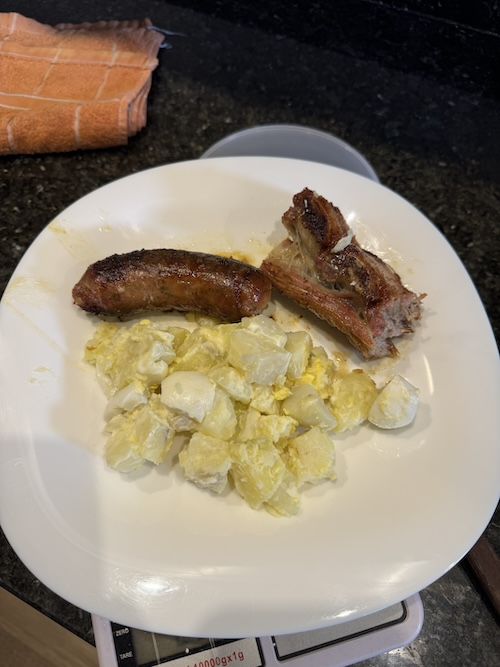

In [49]:
display(Image.open(image_path))

Valores aproximados en gramos:
* 89 chorizo
* 125 asado
* 178 ensalada

In [50]:
rta_img2 = evaluate_image(image_path=image_path, country="Argentina")

In [51]:
format_response(rta_img2)

Status: Ok
Status Message: Successfully extracted foods list from response.
Message for User: None

Parsed Response:
{
    "id": "chatcmpl-9gzXBms4rf1PjW86VqXETQaDnTi0E",
    "object": "chat.completion",
    "created": 1720033341,
    "model": "gpt-4o-2024-05-13",
    "choices": [
        {
            "index": 0,
            "message": {
                "role": "assistant",
                "content": "```json\n[\n    {\n        \"food_name\": \"Sausage\",\n        \"unit\": \"piece\",\n        \"quantity\": 1,\n        \"g_equivalent\": 100,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Pork rib\",\n        \"unit\": \"piece\",\n        \"quantity\": 1,\n        \"g_equivalent\": 150,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Potato\",\n        \"unit\": \"cup\",\n        \"quantity\": 1,\n        \"g_equivalent\": 150,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Mayonnaise\",\n        \"unit\": \"tablesp

# Image 3

In [52]:
image_path = "test-data/tacos.jpg"

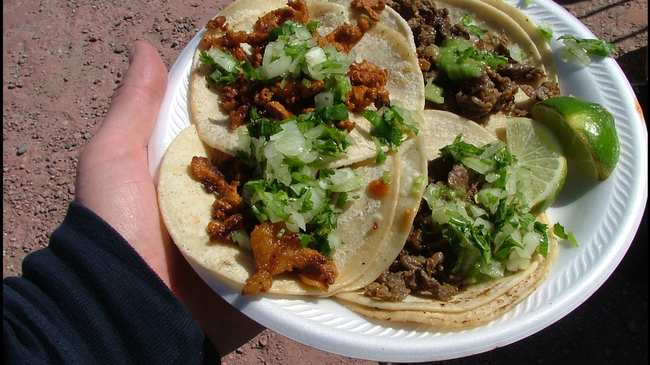

In [53]:
display(Image.open(image_path))

In [54]:
rta_img3 = evaluate_image(image_path=image_path, country="Argentina")

In [55]:
format_response(rta_img3)

Status: Ok
Status Message: Successfully extracted foods list from response.
Message for User: None

Parsed Response:
{
    "id": "chatcmpl-9gzYWgeaeuuCcKgJOvXN5K3H4edyx",
    "object": "chat.completion",
    "created": 1720033424,
    "model": "gpt-4o-2024-05-13",
    "choices": [
        {
            "index": 0,
            "message": {
                "role": "assistant",
                "content": "```json\n[\n    {\n        \"food_name\": \"Tortilla\",\n        \"unit\": \"piece\",\n        \"quantity\": 3,\n        \"g_equivalent\": 90,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Beef\",\n        \"unit\": \"gram\",\n        \"quantity\": 60,\n        \"g_equivalent\": 60,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Pork\",\n        \"unit\": \"gram\",\n        \"quantity\": 60,\n        \"g_equivalent\": 60,\n        \"ml_equivalent\": 0\n    },\n    {\n        \"food_name\": \"Onion\",\n        \"unit\": \"gram\",\n        \